In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e4/sample_submission.csv
/kaggle/input/playground-series-s3e4/train.csv
/kaggle/input/playground-series-s3e4/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 12
FOLDS = 5
STRATEGY = 'median'

In [4]:
df_test = pd.read_csv('/kaggle/input/playground-series-s3e4/test.csv')
df_train = pd.read_csv('/kaggle/input/playground-series-s3e4/train.csv')
df_sample = pd.read_csv('/kaggle/input/playground-series-s3e4/sample_submission.csv')

In [5]:
print('number of rows in train dataset ', df_train.shape[0])
print('number of column in train dataset', df_train.shape[1])
print('number of missing values in train dataset', sum(df_train.isna().sum()))

number of rows in train dataset  219129
number of column in train dataset 32
number of missing values in train dataset 0


In [6]:
df_train.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,...,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000
mean,109564.000000,62377.415376,0.096008,0.048345,0.592102,0.069273,-0.161555,0.133688,-0.128224,0.149534,...,-0.031064,-0.050852,-0.050531,-0.002992,0.124005,0.009881,0.014034,0.017313,66.359803,0.002140
std,63257.237906,25620.348569,1.395425,1.159805,1.132884,1.253125,1.069530,1.202411,0.817207,0.716212,...,0.422777,0.597812,0.318175,0.593100,0.406741,0.473867,0.233355,0.164859,150.795017,0.046214
min,0.000000,0.000000,-29.807725,-44.247914,-19.722872,-5.263650,-37.591259,-25.659750,-31.179799,-28.903442,...,-14.689621,-8.748979,-11.958588,-2.836285,-3.958591,-1.858672,-9.234767,-4.551680,0.000000,0.000000
25%,54782.000000,47933.000000,-0.846135,-0.573728,-0.027154,-0.769256,-0.847346,-0.631835,-0.646730,-0.095948,...,-0.190418,-0.473099,-0.174478,-0.332540,-0.126080,-0.318330,-0.050983,-0.009512,5.990000,0.000000
50%,109564.000000,63189.000000,0.385913,0.046937,0.735895,0.064856,-0.229929,-0.087778,-0.098970,0.111219,...,-0.042858,-0.032856,-0.063307,0.038708,0.145934,-0.086388,0.015905,0.022163,21.900000,0.000000
75%,164346.000000,77519.000000,1.190661,0.814145,1.306110,0.919353,0.356856,0.482388,0.385567,0.390976,...,0.109187,0.354910,0.060221,0.394566,0.402926,0.253869,0.076814,0.066987,68.930000,0.000000
max,219128.000000,120580.000000,2.430494,16.068473,6.145578,12.547997,34.581260,16.233967,39.824099,18.270586,...,22.062945,6.163541,12.734391,4.572739,3.111624,3.402344,13.123618,23.263746,7475.000000,1.000000


In [7]:
df_sample.head()

,id,Class
0,219129,0.5
1,219130,0.5
2,219131,0.5
3,219132,0.5
4,219133,0.5


In [8]:
df_train.drop(["id"] , axis = 1 , inplace = True)
df_test.drop(["id"] , axis = 1 , inplace = True)
TARGET = 'Class'
FEATURES = [col for col in df_train.columns if col != TARGET]
RANDOM_STATE = 12 

In [9]:
df_train.drop(columns = ["Time", "Amount"]).iloc[:, :-1].describe().T.sort_values(by='max' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
V7,219129.000000,-0.128224,0.817207,-31.179799,-0.646730,-0.098970,0.385567,39.824099
V5,219129.000000,-0.161555,1.069530,-37.591259,-0.847346,-0.229929,0.356856,34.581260
V28,219129.000000,0.017313,0.164859,-4.551680,-0.009512,0.022163,0.066987,23.263746
V21,219129.000000,-0.031064,0.422777,-14.689621,-0.190418,-0.042858,0.109187,22.062945
V8,219129.000000,0.149534,0.716212,-28.903442,-0.095948,0.111219,0.390976,18.270586
V6,219129.000000,0.133688,1.202411,-25.659750,-0.631835,-0.087778,0.482388,16.233967
V2,219129.000000,0.048345,1.159805,-44.247914,-0.573728,0.046937,0.814145,16.068473
V10,219129.000000,-0.039758,0.821889,-22.092656,-0.499563,-0.106034,0.403967,15.878405
V20,219129.000000,0.009708,0.439521,-18.679066,-0.167927,-0.037702,0.126750,15.407839
V9,219129.000000,-0.048337,1.054143,-8.756951,-0.711444,-0.131323,0.583715,13.423914


In [10]:
df = pd.concat([df_train[FEATURES], df_test[FEATURES]], axis=0)
cat_features = [col for col in FEATURES if df[col].nunique() < 25 ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 ]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')

Total number of features: 30
Number of categorical features: 0
Number of continuos features: 30


In [11]:
labels=['Categorical', 'Continuos']
values= [len(cat_features), len(cont_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, 
    marker=dict(colors=colors, 
               )
)])
fig.show()

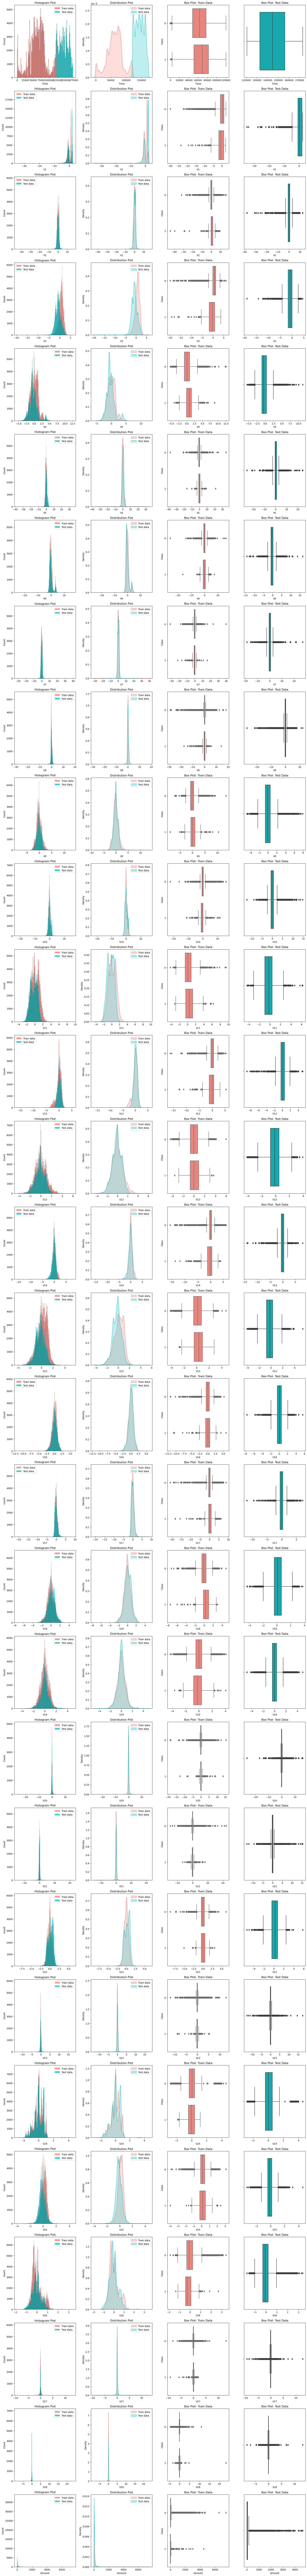

In [12]:
ncols = 4
nrows = len(cont_features)

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5*nrows))

for r in range(nrows):
    row = cont_features[r]
    
    
    sns.histplot(x=df_train[row], ax=axes[r,0], color='#F8766D', label='Train data' , fill =True )
    sns.histplot(x=df_test[row], ax=axes[r,0], color='#00BFC4', label='Test data', fill =True)
    
    sns.kdeplot(x=df_train[row], ax=axes[r,1], color='#F8766D', label='Train data' , fill =True )
    sns.kdeplot(x=df_test[row], ax=axes[r,1], color='#00BFC4', label='Test data', fill =True)
    
    sns.boxplot(x=df_train[row], y = df_train[TARGET], ax=axes[r,2], color='#F8766D', orient = "h")
    sns.boxplot(x=df_test[row], ax=axes[r,3], color='#00BFC4', orient = "h")
    
    axes[r,0].legend()
    axes[r,1].legend()
    axes[r,0].title.set_text("Histogram Plot")
    axes[r,1].title.set_text("Distribution Plot")
    axes[r,2].title.set_text("Box Plot- Train Data")
    axes[r,3].title.set_text("Box Plot- Test Data")
fig.tight_layout()
plt.show()